In [1]:
# Packages for general use
import numpy as np
import pandas as pd

# For handling data
from sklearn import preprocessing
import rasterio as rio

# Modeling
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Data Loading and Wrangling

In [2]:
# Land cover data and functions

lc_file = rio.open("Data/LandCoverData.tif")
lc_map = lc_file.read(1)

def location_to_geo_data(lon, lat): 
    #transforms coordinates (longitude, latitude) into geographic data found in raster file
    if np.isnan(lon) or np.isnan(lat):
        return -1 #np.nan; NOTE: 0 denotes no class available for our purposes; 
                 #   the original raster file data is indexed from 0-16, which we will shift into 1-17 to compensate for 0
    else:
        x,y = lc_file.index(lon,lat)
        return lc_map[x,y]+1

extract_geo_data = np.vectorize(location_to_geo_data)

In [3]:
# Functions for manipulating raw data
# Extraction

def extract_files_of_year(year):
    #reads csv files
    
    deets = pd.read_csv("Data/Details_"+str(year)+".csv")
    locs = pd.read_csv("Data/Locations_"+str(year)+".csv")
    fatals = pd.read_csv("Data/Fatalities_"+str(year)+".csv")
    
    #print(deets.columns)
    #print(locs.columns)
    #print(fatals.columns,"\n done extracting!")   
    return deets, locs, fatals

# Transformations

def filter_and_join(deets, locs, fatals):
    #performs all filters and joins on data for details, locations, and fatalities
    
    death_cols = ['DEATHS_DIRECT','DEATHS_INDIRECT']
    
    events = deets[deets[death_cols].sum(axis=1)>0.0]    #restrict scope to events that have fatalities
    events = pd.merge(events, locs, on=['EPISODE_ID','EVENT_ID'], how='left')
    
    #print(events.columns)
    
    events = events.loc[:,~events.columns.duplicated()]   #remove duplicate columns from merging
    return events

def transform_deets(deets):
    #Group storm events into broader by closely related categories
    aliases = ['EVENT_TYPE', 'END_DATE_TIME', 'BEGIN_DATE_TIME']
    a = deets[aliases[0]].copy()
    a[a.str.match(".*Flood$")] = "Flood"
    a[a.str.match(".*Wind$")] = "Wind"
    a[a.str.contains(".*Hail$")] = "Hail"
    deets[aliases[0]] = a
    
    death_cols = ['DEATHS_DIRECT','DEATHS_INDIRECT']
    
    deets['DURATION'] = (pd.to_datetime(deets[aliases[1]]).subtract(pd.to_datetime(deets[aliases[1]]))
                        ).astype('timedelta64[h]')
    deets['DEATHS'] = deets[death_cols].sum(axis=1)
    #deets['DAMAGES'] = deets[damage_cols].sum(axis=1) #need to parse strings, and convert to numeric!
    #print("done with deets!")
    return deets

def transform_locs(locs):
    #Impute if necessary, then map coordinates to land-cover classes
    #print("loc columns: ",locs.columns)
    aliases = ['LONGITUDE','LATITUDE','BEGIN_LON','BEGIN_LAT']
    
    locs['LONGITUDE'] = locs[aliases[0]].fillna(locs[aliases[2]])  #impute values from another column with coordinates
    locs['LATITUDE'] = locs[aliases[1]].fillna(locs[aliases[3]]) 
    locs['LAND_COVER_CLASS'] = extract_geo_data(locs[aliases[0]],locs[aliases[1]])
    return locs
    
def transform_fatals(fatals):
    #Repaired entries of the fatalities file to match documentation description
    aliases = ['FATALITY_LOCATION']
    a = fatals[aliases[0]].copy()
    a[a.str.match("Boat.*")] = "Boating"
    a[a.str.match("Other|Unknown")] = "Other/Unknown"
    fatals[aliases[0]] = a
    
    return fatals

def assemble_data_sets_of_year(year):
    #Extracts and transforms all data files of a given year
    deets, locs, fatals = extract_files_of_year(year)
    events = filter_and_join(deets, locs, fatals)
    events = (events
        .pipe(transform_deets)
        .pipe(transform_locs)
    )
    fatals = transform_fatals(fatals)
    
    #desired_event_columns = ['EVENT_ID', 'EVENT_TYPE', 'MAGNITUDE', 'FLOOD_CAUSE', 'LONGITUDE', 'LATITUDE',
    #                         'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 
    #                         'DURATION', 'LAND_COVER_CLASS', 'DEATHS', 'STATE','CZ_NAME']
    #events = events[desired_event_columns] 
    return events, fatals

Note that in years 1996-2005, no data was collected on the FLOOD_CAUSE column.

In [51]:
#Extract, transform, and load data from years [1996, 2020)

events, fatals = zip(*[assemble_data_sets_of_year(year) for year in range(2006, 2020)])
all_events = pd.concat(events)
all_events['LAND_COVER_CLASS'] = all_events['LAND_COVER_CLASS'].replace(-1,np.nan)
all_fatals = pd.concat(fatals)

In [35]:
# Accumulate all locations of fatalities for each event, and merge with event details

l = ['EVENT_ID','FATALITY_LOCATION']
to_agg = all_fatals[l]
to_merge = to_agg.groupby(['EVENT_ID'], as_index=False).agg({'FATALITY_LOCATION': lambda s: tuple(pd.unique(s))})
all_events_with_fatals = pd.merge(all_events, to_merge, on=['EVENT_ID'], how='left')

# Observations

## Visual Distribution

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

[]

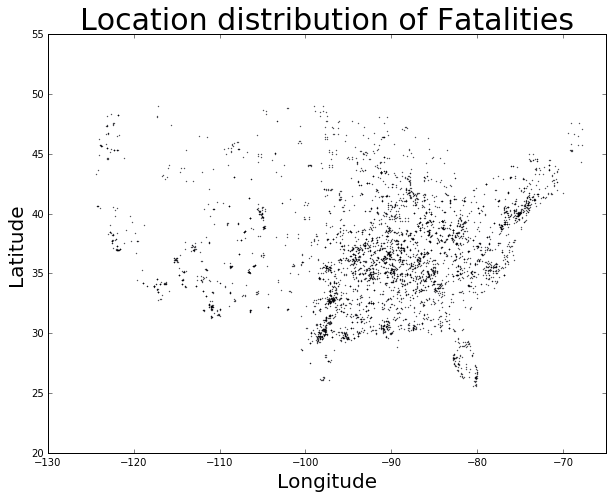

In [9]:
df_with_location = all_events_with_fatals[["LONGITUDE","LATITUDE"]]
plt.figure(figsize=(10,7.5))
plt.scatter(df_with_location["LONGITUDE"],df_with_location["LATITUDE"],s=0.1)
plt.xlim((-130,-65))
plt.ylim((20,55))
plt.title("Location distribution of Fatalities",fontsize=30)
plt.xlabel("Longitude",fontsize=20)
plt.ylabel("Latitude",fontsize=20)
plt.plot()

# Feature Engineering

## Proximity to Hospitals (Care Facilities), Number of Hospitals in County + State

Link to hospital dataset: https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals/geoservice

In [12]:
from scipy import spatial
import requests, json

In [10]:
def cartesian(latitude, longitude, elevation = 0):
    # Convert to radians
    latitude = latitude * (np.pi / 180)
    longitude = longitude * (np.pi / 180)

    R = 6371 + elevation  # radius of earth in km
    X = R * np.cos(latitude) * np.cos(longitude)
    Y = R * np.cos(latitude) * np.sin(longitude)
    Z = R * np.sin(latitude)
    return np.column_stack(np.array([X, Y, Z]))

def closest_loc(lat, lon, tree):
    cartesian_coord = cartesian(lat, lon)
    dist, index = tree.query(cartesian_coord, p = 2) #query runs in linear time w.r.t. input size, sub-linear w.r.t. KDtree size
    return dist

state_abbrev = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
state_names = ["ALABAMA", "ALASKA", "ARIZONA", "ARKANSAS", "CALIFORNIA", "COLORADO",
          "CONNECTICUT", "DELAWARE", "FLORIDA", "GEORGIA", "HAWAII", "IDAHO", "ILLINOIS",
          "INDIANA", "IOWA", "KANSAS", "KENTUCKY", "LOUISIANA", "MAINE", "MARYLAND",
          "MASSACHUSETTS", "MICHIGAN", "MINNESOTA", "MISSISSIPPI", "MISSOURI", "MONTANA",
          "NEBRASKA", "NEVADA", "NEW HAMPSHIRE", "NEW JERSEY", "NEW MEXICO", "NEW YORK",
          "NORTH CAROLINA", "NORTH DAKOTA", "OHIO", "OKLAHOMA", "OREGON", "PENNSYLVANIA",
          "RHODE ISLAND", "SOUTH CAROLINA", "SOUTH DAKOTA", "TENNESSEE", "TEXAS", "UTAH",
          "VERMONT", "VIRGINIA", "WASHINGTON", "WEST VIRGINIA", "WISCONSIN", "WYOMING"]
state_ref_dict = dict(zip(state_abbrev, state_names))

In [13]:
acc = []
for abb in state_abbrev:
    query_url = "https://services1.arcgis.com/Hp6G80Pky0om7QvQ/arcgis/rest/services/Hospitals_1/FeatureServer/0/query?where=STATUS%20%3D%20'OPEN'%20AND%20STATE%20like%20'%25"+abb+"%25'&outFields=NAME,STATE,ZIP,LONGITUDE,COUNTY,LATITUDE&outSR=4326&f=json"
    hospitals_json = requests.get(query_url)
    df = pd.DataFrame.from_records(pd.DataFrame(hospitals_json.json()['features'])['attributes'])
    acc.append(df)

In [14]:
hospitals_df = pd.concat(acc)
hospitals_df['STATE'] = hospitals_df['STATE'].map(state_ref_dict)
hospitals_locs = cartesian(hospitals_df["LATITUDE"].values, hospitals_df["LONGITUDE"].values)
tree = spatial.KDTree(hospitals_locs)

In [36]:
#Find distance to nearest hospital

all_events_with_fatals['CLOSEST_HOSPITAL_DIST'] = closest_loc(df_with_location["LATITUDE"].values, df_with_location["LONGITUDE"].values, tree)
all_events_with_fatals['CLOSEST_HOSPITAL_DIST'] = all_events_with_fatals['CLOSEST_HOSPITAL_DIST'].replace(np.inf, np.nan)

In [37]:
#Find number of hospitals in each county and state

county_hospital_counts = (
    hospitals_df
    .groupby(['STATE','COUNTY'], as_index=False)
    .agg({'NAME':'count'})
    .rename(columns={'NAME':'NUM_COUNTY_HOSPITALS', 'COUNTY':'CZ_NAME'})
)
state_hospital_counts = (
    hospitals_df
    .groupby(['STATE'], as_index=False)
    .agg({'NAME':'count'})
    .rename(columns={'NAME':'NUM_STATE_HOSPITALS'})
)
all_events_with_fatals = pd.merge(all_events_with_fatals, county_hospital_counts, on=['STATE','CZ_NAME'], how='left')
all_events_with_fatals = pd.merge(all_events_with_fatals, state_hospital_counts, on=['STATE'], how='left')

In [41]:
#Impute missing values with zeroes since they are counts

all_events_with_fatals['NUM_COUNTY_HOSPITALS'].fillna(0, inplace=True)
all_events_with_fatals['NUM_STATE_HOSPITALS'].fillna(0, inplace=True)

## Extracting Features from Text

In [46]:
#Impute, then create features

all_events_with_fatals['EPISODE_NARRATIVE'].fillna('', inplace=True)
all_events_with_fatals['EVENT_NARRATIVE'].fillna('', inplace=True)

all_events_with_fatals['EPISODE_LENGTH'] = all_events_with_fatals['EPISODE_NARRATIVE'].str.split().str.len()
all_events_with_fatals['EVENT_LENGTH'] = all_events_with_fatals['EVENT_NARRATIVE'].str.split().str.len()

In [47]:
all_events_with_fatals.columns

Index([u'BEGIN_YEARMONTH', u'BEGIN_DAY', u'BEGIN_TIME', u'END_YEARMONTH',
       u'END_DAY', u'END_TIME', u'EPISODE_ID', u'EVENT_ID', u'STATE',
       u'STATE_FIPS', u'YEAR', u'MONTH_NAME', u'EVENT_TYPE', u'CZ_TYPE',
       u'CZ_FIPS', u'CZ_NAME', u'WFO', u'BEGIN_DATE_TIME', u'CZ_TIMEZONE',
       u'END_DATE_TIME', u'INJURIES_DIRECT', u'INJURIES_INDIRECT',
       u'DEATHS_DIRECT', u'DEATHS_INDIRECT', u'DAMAGE_PROPERTY',
       u'DAMAGE_CROPS', u'SOURCE', u'MAGNITUDE', u'MAGNITUDE_TYPE',
       u'FLOOD_CAUSE', u'CATEGORY', u'TOR_F_SCALE', u'TOR_LENGTH',
       u'TOR_WIDTH', u'TOR_OTHER_WFO', u'TOR_OTHER_CZ_STATE',
       u'TOR_OTHER_CZ_FIPS', u'TOR_OTHER_CZ_NAME', u'BEGIN_RANGE',
       u'BEGIN_AZIMUTH', u'BEGIN_LOCATION', u'END_RANGE', u'END_AZIMUTH',
       u'END_LOCATION', u'BEGIN_LAT', u'BEGIN_LON', u'END_LAT', u'END_LON',
       u'EPISODE_NARRATIVE', u'EVENT_NARRATIVE', u'DATA_SOURCE', u'YEARMONTH',
       u'LOCATION_INDEX', u'RANGE', u'AZIMUTH', u'LOCATION', u'LATITUDE',
       u'

In [55]:
#Proof that no more coordinates can be imputed
np.sum(all_events_with_fatals['LATITUDE'].isna()), np.sum((all_events_with_fatals['LATITUDE'].fillna(all_events_with_fatals['LAT2'])).isna())

(4100, 4100)

## Subsetting and Encoding

In [48]:
desired_event_columns = [
    'EVENT_TYPE', 'MAGNITUDE', 'FLOOD_CAUSE', 
    'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 
    'DURATION', 'LAND_COVER_CLASS', 'FATALITY_LOCATION', #Computed or combined columns from other sources
    'CLOSEST_HOSPITAL_DIST', 'NUM_COUNTY_HOSPITALS', 'NUM_STATE_HOSPITALS', #From hospital data
    'EPISODE_LENGTH', 'EVENT_LENGTH', #From text
    'DEATHS'
]

In [49]:
all_events_feats = all_events_with_fatals[desired_event_columns]

In [50]:
#Encoding

#One-hot encoding
all_events_feats = (all_events_with_fatals
    .pipe(pd.get_dummies, prefix_sep='_', drop_first=False, columns=['FLOOD_CAUSE','LAND_COVER_CLASS'])
    .pipe(pd.get_dummies, prefix_sep='_', drop_first=False, columns=['TOR_F_SCALE']) #ordinal encoding (temporarily as one-hot)
)

#Multi-hot encoding
mlb = preprocessing.MultiLabelBinarizer()
feature_column_name = 'FATALITY_LOCATION'
feature_column = all_events_feats[feature_column_name]

mask = feature_column.notnull() #Save location non-missing values, allows us to restore original indices after filtering na's

feature_matrix = mlb.fit_transform(all_events_feats[feature_column_name].dropna()) #Drop missing values and encode

df = pd.DataFrame(feature_matrix, index=all_events_feats.index[mask], columns=feature_column_name+"_"+mlb.classes_) \
    .reindex(all_events_feats.index, fill_value=0)  #restore original matrix with missing values - encoded as all 0's
    
all_events_feats = all_events_feats.join(df).drop([feature_column_name], axis=1)

### Idea: Keyword extraction from narratives?

In [ ]:
from rake_nltk import Rake

# Uncomment lines below if Rake requires resources
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

In [ ]:
all_events_feats[all_events_feats['EVENT_TYPE']=='Heat'][['EPISODE_NARRATIVE','EVENT_NARRATIVE']]

In [ ]:
all_events_feats[all_events_feats['EVENT_TYPE']=='Heat']['EVENT_NARRATIVE']

In [ ]:
r = Rake()
mytext = all_events_feats['EVENT_NARRATIVE'][10]
#mytext = all_events_feats['EPISODE_NARRATIVE'][0]
r.extract_keywords_from_text(mytext)
r.get_ranked_phrases()